In [39]:
#the point of this is to generate a master_dataframe_that_contains_binding
#information as well as gene expression information to allow for separating
#into interesting groups

#I will also plot the data normalized by gene expression and not normalized by gene expression
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
%matplotlib inline
#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples
header_list=['chrom','start','end','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_merge_final_union.bg',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+1,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+1,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+1,2)-log(row['hnM_DMSO']+1,2)),axis=1)
#now I need to generate a bedtool and intersect with the FAST-iCLIP genes file
#Note - I am concerned that the clipper file does not match the RT stops - need
#to take a look at how Brian extracted these.
#print a file and get it the dataframe as a bedtool
hnM_DMSO_TAM_final_union_df.to_csv('hnM_DMSO_TAM_final_union_with_log2ratio',\
                                  sep='\t',index=False,header=False)
hnM_DMSO_TAM_final_df_bt = pbt.BedTool(fn='hnM_DMSO_TAM_final_union_with_log2ratio')
#other idea - just overlap with genes without strandedness and then merge so that
#the gene name contains both genes
hg19_ensembl_genes = pbt.BedTool(fn='/Users/Sam/bin/FAST-iCLIP/docs/hg19_ensembl_genes_BED6.bed')
#merge this so that gene names overlap
# hg19_ensembl_genes_merge = hg19_ensembl_genes.merge(c=4,o='distinct',s=True).saveas('hg19_ensembl_genes_merge')
#intersect with hnM_DMSO_TAM_final
hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect = hnM_DMSO_TAM_final_df_bt.intersect(b=hg19_ensembl_genes,wao=True).saveas('hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect')
#now merge this on columns 4,5,6,7,8,12
hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect_merge = hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect.merge(c=[4,5,6,7,8,12],o='distinct').saveas('hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect_merge')
#now read this in as a dataframe
header_list=['chrom','start','end','hnM_DMSO','hnM_TAM','hnM_DMSO_1','hnM_TAM_1','log2ratio_TAM_DMSO','ens_gene']
hnM_DMSO_TAM_final_union_genes_df = pd.read_csv('hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect_merge',sep='\t',names = header_list)
#now it is time to load the gene expression data
twist_gene_exp_df = pd.read_csv('twist_gene_exp.diff',sep='\t',usecols=[1,2,3,7,8],header=0, names=['ens_gene','gene','gene_coords','twist_d0','twist_d14'])
#now I need to merge the dataframes based on the column ens_gene. The problem is
#that ens_gene is not unique, so there is a loss of clusters
#This merge command just keeps all of the columns that agree on ens_gene
merge_df = pd.merge(hnM_DMSO_TAM_final_union_genes_df,twist_gene_exp_df,on='ens_gene')
#You've got to go back and fix this later... deal with the duplicates somehow
#now add a column with +1 for each and log2ratio
merge_df['twist_d0_1'] = merge_df.apply(lambda row: row['twist_d0']+1,axis=1)
merge_df['twist_d14_1'] = merge_df.apply(lambda row: row['twist_d14']+1,axis=1)
merge_df['log2ratio_d14_d0'] = merge_df.apply(lambda row: (log(row['twist_d14']+1,2)-log(row['twist_d0']+1,2)),axis=1)


#now sort out the different categories with 2 fold (0.5) thresholds
#Remember --> I did not normalize binding intensity based on gene expression
#because there is not a perfect correlation here. Instead, look for opposite relationships


#Keep rows with FPKM threshold or more in at least one sample
fpkm_threshold = 5
merge_df_high_genes = merge_df[(merge_df.twist_d0 >= fpkm_threshold) & (merge_df.twist_d14 >= fpkm_threshold)]

#set a log2 fold_change ratio and print different groups
threshold = 0.5
comparison_list = []

#1. no binding changes, no gene expression changes
merge_df_no_bind_no_gene = merge_df[merge_df.log2ratio_TAM_DMSO.abs() < threshold]
merge_df_no_bind_no_gene = merge_df_no_bind_no_gene[merge_df_no_bind_no_gene.log2ratio_d14_d0.abs() < threshold]
merge_df_no_bind_no_gene.to_csv('comparison_df/no_bind_no_gene',sep='\t',index=False)

#2. binding changes, no gene expression changes
merge_df_bind_no_gene = merge_df[merge_df.log2ratio_d14_d0.abs() < threshold]
merge_df_bind_no_gene = merge_df_bind_no_gene[merge_df_bind_no_gene.log2ratio_TAM_DMSO.abs() >= threshold]
merge_df_bind_no_gene.to_csv('comparison_df/bind_no_gene',sep='\t',index=False)

#3. no binding changes, gene expression changes
merge_df_no_bind_gene = merge_df_high_genes[merge_df_high_genes.log2ratio_TAM_DMSO.abs() < threshold]
merge_df_no_bind_gene = merge_df_no_bind_gene[merge_df_no_bind_gene.log2ratio_d14_d0.abs() >= threshold]
merge_df_no_bind_gene.to_csv('comparison_df/no_bind_gene',sep='\t',index=False)

#4. binding changes, gene expression changes
merge_df_bind_gene = merge_df_high_genes[merge_df_high_genes.log2ratio_TAM_DMSO.abs() >= threshold]
merge_df_bind_gene = merge_df_bind_gene[merge_df_bind_gene.log2ratio_d14_d0.abs() >= threshold]
merge_df_bind_gene.to_csv('comparison_df/bind_gene',sep='\t',index=False)

#now we should further sort the genes in the following
#bind_gene - bind is >= 0.5, but gene < 0.5
merge_df_bind_up_gene_down = merge_df_bind_gene[merge_df_bind_gene.log2ratio_TAM_DMSO >= 0.5]
merge_df_bind_up_gene_down = merge_df_bind_up_gene_down[merge_df_bind_up_gene_down.log2ratio_d14_d0 < 0.5]
merge_df_bind_up_gene_down.to_csv('comparison_df/bind_up_gene_down',sep='\t',index=False)
#bind_gene - bind is < 0.5, but gene >= 0.5
merge_df_bind_down_gene_up = merge_df_bind_gene[merge_df_bind_gene.log2ratio_TAM_DMSO < 0.5]
merge_df_bind_down_gene_up = merge_df_bind_down_gene_up[merge_df_bind_down_gene_up.log2ratio_d14_d0 >= 0.5]
merge_df_bind_down_gene_up.to_csv('comparison_df/bind_down_gene_up',sep='\t',index=False)

# #write to excel
# writer = pd.ExcelWriter('~/Desktop/comparison_excel.xlsx')
# merge_df_no_bind_no_gene.to_excel(writer,'no_bind_no_gene')
# merge_df_bind_no_gene.to_excel(writer,'bind_no_gene')
# merge_df_no_bind_gene.to_excel(writer,'no_bind_gene')
# merge_df_bind_gene.to_excel(writer,'bind_gene')
# merge_df_bind_up_gene_down.to_excel(writer,'bind_up_gene_down')
# merge_df_bind_down_gene_up.to_excel(writer,'bind_down_gene_up')


In [30]:
merge_df[0:4]

,chrom,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,ens_gene,gene,gene_coords,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0
0,chr1,251639,251647,14.219565,0.000000,15.219565,1.000000,-3.927855,ENSG00000228463,AP006222.2,chr1:227614-267253,0.040763,0.117389,1.040763,1.117389,0.10249
1,chr1,566242,566254,112.662709,135.544767,113.662709,136.544767,0.264615,ENSG00000230021,RP5-857K21.4,chr1:536815-755214,0.000000,0.000000,1.000000,1.000000,0.00000
2,chr1,566269,566270,8.750502,0.000000,9.750502,1.000000,-3.285476,ENSG00000230021,RP5-857K21.4,chr1:536815-755214,0.000000,0.000000,1.000000,1.000000,0.00000
3,chr1,566278,566279,0.000000,7.041287,1.000000,8.041287,3.007426,ENSG00000230021,RP5-857K21.4,chr1:536815-755214,0.000000,0.000000,1.000000,1.000000,0.00000


In [15]:
len(merge_df)

172631

In [16]:
len(merge_df_high_genes)

85685

In [37]:
#lengths - shows how much is lost
print(len(hnM_DMSO_TAM_final_union_df),len(twist_gene_exp_df),len(merge_df))

(190938, 57146, 172631)


,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO
start,1.000000,1.000000,-0.003897,-0.002235,-0.003897,-0.002235,0.014556
end,1.000000,1.000000,-0.003897,-0.002235,-0.003897,-0.002235,0.014556
hnM_DMSO,-0.003897,-0.003897,1.000000,0.813531,1.000000,0.813531,-0.092806
hnM_TAM,-0.002235,-0.002235,0.813531,1.000000,0.813531,1.000000,0.090004
hnM_DMSO_1,-0.003897,-0.003897,1.000000,0.813531,1.000000,0.813531,-0.092806
hnM_TAM_1,-0.002235,-0.002235,0.813531,1.000000,0.813531,1.000000,0.090004
log2ratio_TAM-DMSO,0.014556,0.014556,-0.092806,0.090004,-0.092806,0.090004,1.000000


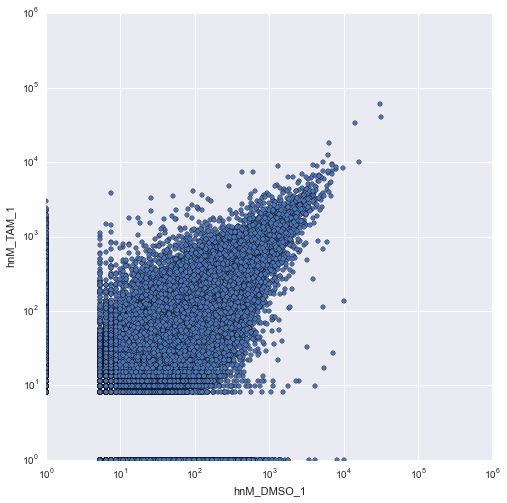

In [43]:
#No gene expression normalization
ax_none_gene_norm = hnM_DMSO_TAM_final_union_df.plot(kind='scatter',x='hnM_DMSO_1',y='hnM_TAM_1',figsize=(8,8),loglog=True,xlim=(1,10e5),ylim=(1,10e5))
hnM_DMSO_TAM_final_union_df.corr()

In [44]:
merge_df_high_genes[0:3]

,chrom,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,ens_gene,gene,gene_coords,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0,hnM_TAM_1_gene_norm
22,chr1,890202,890203,13.125752,12.322252,14.125752,13.322252,-0.084490,ENSG00000188976,NOC2L,chr1:860259-894689,59.7222,106.213,60.7222,107.213,0.820184,7.54532
23,chr1,890741,890742,10.938127,0.000000,11.938127,1.000000,-3.577505,ENSG00000188976,NOC2L,chr1:860259-894689,59.7222,106.213,60.7222,107.213,0.820184,0.56637
24,chr1,890776,890784,12.031940,0.000000,13.031940,1.000000,-3.703980,ENSG00000188976,NOC2L,chr1:860259-894689,59.7222,106.213,60.7222,107.213,0.820184,0.56637


/Users/Sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0,hnM_TAM_1_gene_norm
start,1.000000,1.000000,0.016492,0.017761,0.016492,0.017761,0.014755,0.035466,0.057395,0.035466,0.057395,-0.117277,0.027844
end,1.000000,1.000000,0.016493,0.017761,0.016493,0.017761,0.014755,0.035466,0.057395,0.035466,0.057395,-0.117277,0.027845
hnM_DMSO,0.016492,0.016493,1.000000,0.832909,1.000000,0.832909,-0.077914,0.031479,-0.002352,0.031479,-0.002352,-0.083939,0.770890
hnM_TAM,0.017761,0.017761,0.832909,1.000000,0.832909,1.000000,0.093351,0.002641,-0.000643,0.002641,-0.000643,-0.024400,0.879596
hnM_DMSO_1,0.016492,0.016493,1.000000,0.832909,1.000000,0.832909,-0.077914,0.031479,-0.002352,0.031479,-0.002352,-0.083939,0.770890
hnM_TAM_1,0.017761,0.017761,0.832909,1.000000,0.832909,1.000000,0.093351,0.002641,-0.000643,0.002641,-0.000643,-0.024400,0.879596
log2ratio_TAM_DMSO,0.014755,0.014755,-0.077914,0.093351,-0.077914,0.093351,1.000000,-0.040878,0.020867,-0.040878,0.020867,0.106580,0.075509
twist_d0,0.035466,0.035466,0.031479,0.002641,0.031479,0.002641,-0.040878,1.000000,0.680975,1.000000,0.680975,-0.044590,0.006053
twist_d14,0.057395,0.057395,-0.002352,-0.000643,-0.002352,-0.000643,0.020867,0.680975,1.000000,0.680975,1.000000,0.158201,-0.013213
twist_d0_1,0.035466,0.035466,0.031479,0.002641,0.031479,0.002641,-0.040878,1.000000,0.680975,1.000000,0.680975,-0.044590,0.006053


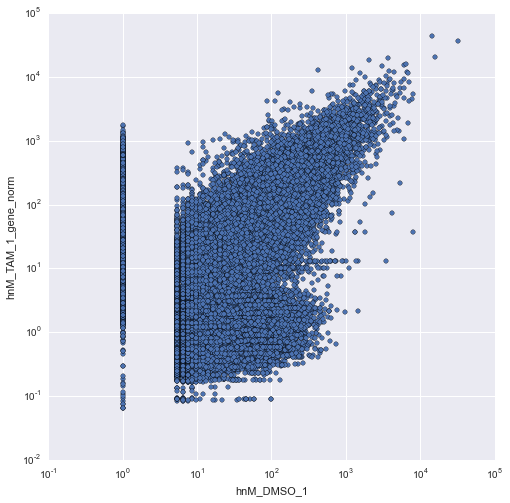

In [45]:
#with gene expression normalization - make sure to only use dataframe with genes that are expressed in at least one condition at threshold
# merge_df_high_genes['hnM_DMSO_1_gene_norm'] = 
merge_df_high_genes['hnM_TAM_1_gene_norm'] = merge_df_high_genes.apply(lambda row: (row['hnM_TAM_1']) / (2**(row['log2ratio_d14_d0'])),axis=1)
ax_with_gene_norm = merge_df_high_genes.plot(kind='scatter',x='hnM_DMSO_1',y='hnM_TAM_1_gene_norm',figsize=(8,8),loglog=True)
merge_df_high_genes.corr()

In [42]:
merge_df_high_genes[:3]
len(merge_df_high_genes)

85685

In [39]:
#note - it would be better for me to use the clipper assignment because it keeps the strand
#idea - take the clipper, pull out the genes, take only those genes from the hg19_ensembl_genes,
#then intersect
# gene_list=[]
# with open('hnM_DMSO_files/hnM_DMSO_clipper_lowFDRreads_centerCoord_collapse.bed') as infile:
#     readlines = infile.readlines()
#     for line in readlines:
#         line = line.strip().split('\t')
#         gene_list.append(line[3])
# simple_gene_list = []
# for item in gene_list:
#     gene = item.split('.')[0]
#     simple_gene_list.append(gene)
# with open('hnM_TAM_files/hnM_TAM_clipper_lowFDRreads_centerCoord_collapse.bed') as infile:
#     readlines = infile.readlines()
#     for line in readlines:
#         line = line.strip().split('\t')
#         gene_list.append(line[3])
# simple_gene_list = []
# for item in gene_list:
#     gene = item.split('.')[0]
#     simple_gene_list.append(gene)

# simple_gene_list = list(set(simple_gene_list))

# final_gene_list = []
# with open('/Users/Sam/bin/FAST-iCLIP/docs/hg19_ensembl_genes_BED6.bed') as infile:
#     readlines = infile.readlines()
#     for line in readlines:
#         gene = line.strip().split('\t')[3]
#         if gene in simple_gene_list:
#             final_gene_list.append(line)
            
# with open('hg19_ensembl_genes_from_hnM_DMSO_TAM_clipper')
                